# Car insurance claim prediction - Introduction

We will explore and build a model on the basis of car insurance claims dataset, already loaded inside a local sqlite databasee

## Load data

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy import stats
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

In [40]:
# create connection to sqlite db file
db = create_engine("sqlite:///../db/test.db")

conn = db.connect()

try:

    # load data from sqlite
    df = pd.read_sql(
        sql="original_data", #  table name
        con=conn,
        index_col=["Household_ID", "Vehicle"]
    )
    conn.close()
except Exception as e:
    raise e

    
df.drop(labels="Row_ID", inplace=True, axis=1)

In [41]:
total_records = len(df)
duplicate_households = df.index.get_level_values(0).duplicated().sum()
duplicate_households_vehicle =  df.index.duplicated().sum()

print("Total data points: ", total_records)
print("Duplicate households: ", duplicate_households)
print("Duplicate household - vehicle combinations: ", duplicate_households_vehicle)

Total data points:  100000
Duplicate households:  1397
Duplicate household - vehicle combinations:  433


The dataset contains **100K** data points on car insurance claims. Each row represents an insurance claim policy for a single household car, car and non car variables and finnaly **`Claim_Amount`**. Our goal is to:

>build a model, which models the influence of **selected parameters** (present in the original dataset
> distribution of insurance claim amounts

## Method

To build the model we will do the following steps:

1. **Exploration**
 - data transformation, cleaning
 - new features
2. **Build model(s)**
 - strategy and alternatives
 - preprocessing
 - test & train split
 - model assessment

# Exploration

In [42]:
df.head()

,,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,Cat4,Cat5,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
Household_ID,Vehicle,,,,,,,,,,,,,,,,,,,,,
6459234,4,2007,1998,G,G.8,G.8.3,F,?,A,B,A,...,-0.965540,-1.004587,-1.439141,-0.918689,N,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1875568,1,2007,2004,BZ,BZ.11,BZ.11.2,B,A,A,A,A,...,-0.828755,-1.036169,-0.714171,-0.941224,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4010054,4,2006,2003,Y,Y.42,Y.42.2,F,C,A,C,A,...,0.402303,-0.288724,-0.923061,-0.197237,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
922766,3,2006,1983,BW,BW.49,BW.49.1,H,?,C,?,?,...,-0.769284,0.182669,2.050541,-1.439512,N,-0.23153,-0.266117,2.715490,-0.251419,0.0
6289123,5,2005,1999,BW,BW.166,BW.166.0,I,C,A,?,?,...,0.503405,1.427241,0.932369,0.907092,M,-0.23153,-0.266117,4.209404,-0.251419,0.0


In [43]:
# Some categories contain ? instead of NaN, lets replace them
# we might later impute the missing values 
df.replace("?", np.nan, inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100000 entries, (6459234, 4) to (3804606, 2)
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Calendar_Year   100000 non-null  int64  
 1   Model_Year      100000 non-null  int64  
 2   Blind_Make      99937 non-null   object 
 3   Blind_Model     99937 non-null   object 
 4   Blind_Submodel  99937 non-null   object 
 5   Cat1            99791 non-null   object 
 6   Cat2            63204 non-null   object 
 7   Cat3            99970 non-null   object 
 8   Cat4            57006 non-null   object 
 9   Cat5            56951 non-null   object 
 10  Cat6            99791 non-null   object 
 11  Cat7            45296 non-null   object 
 12  Cat8            99971 non-null   object 
 13  Cat9            100000 non-null  object 
 14  Cat10           99970 non-null   object 
 15  Cat11           99770 non-null   object 
 16  Cat12           99789 non-null   object

In [45]:
na_counts = []
len_df = len(df)
for col in df.columns:
    na_value_perc = (df[col].isna().sum()/len_df)*100
    na_counts.append({"column": col, "na_perc": na_value_perc})

na_df = pd.DataFrame(na_counts)
print(na_df.loc[na_df.na_perc > 0].sort_values(by="na_perc", ascending=False))

            column  na_perc
11            Cat7   54.704
9             Cat5   43.049
8             Cat4   42.994
6             Cat2   36.796
15           Cat11    0.230
16           Cat12    0.211
5             Cat1    0.209
10            Cat6    0.209
2       Blind_Make    0.063
3      Blind_Model    0.063
4   Blind_Submodel    0.063
17          OrdCat    0.056
7             Cat3    0.030
14           Cat10    0.030
12            Cat8    0.029


We see that `Cat 7, 5, 4, 2` have more than 35% up to 55% missing values, we will drop this variables from further consideration for the model inupts

## `Model_Year`

In [46]:
df = df.drop(labels=["Cat7", "Cat5", "Cat4", "Cat2"], axis=1)

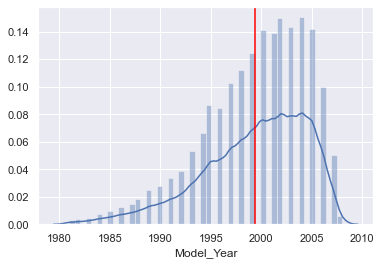

In [47]:
sns.distplot(df.Model_Year)
plt.axvline(df.Model_Year.mean(), c="red")

The majority of cars in dataset appear to be made between 1995 and 2005. Because we have information about the calendar year of the policies, we can calculate approximate age at the time of the polixy as a possible feature.

In [48]:
df = df.assign(Car_Age= lambda x: x.Calendar_Year - x.Model_Year)

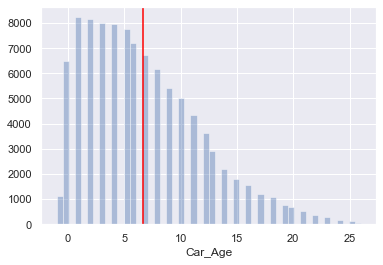

count    100000.000000
mean          6.711950
std           5.147798
min          -1.000000
25%           3.000000
50%           6.000000
75%          10.000000
max          26.000000
Name: Car_Age, dtype: float64


In [49]:
sns.distplot(a=df.Car_Age, kde=False)
plt.axvline(df.Car_Age.mean(), c="red")
plt.show()
print(df.Car_Age.describe())

In [50]:
print(f"No. of cars with Calendar year (of policy) before Model_Year: {len(df.Car_Age[df.Car_Age<0])}")

No. of cars with Calendar year (of policy) before Model_Year: 1136


In [51]:
# some cars were insured before `Model_Year`, so we will mark them as 0 years old 
df.loc[df.Car_Age < 0, "Car_Age"] = 0

/Users/rok-mi/my_projects/ektimo-test/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### What does car age say about claim amount

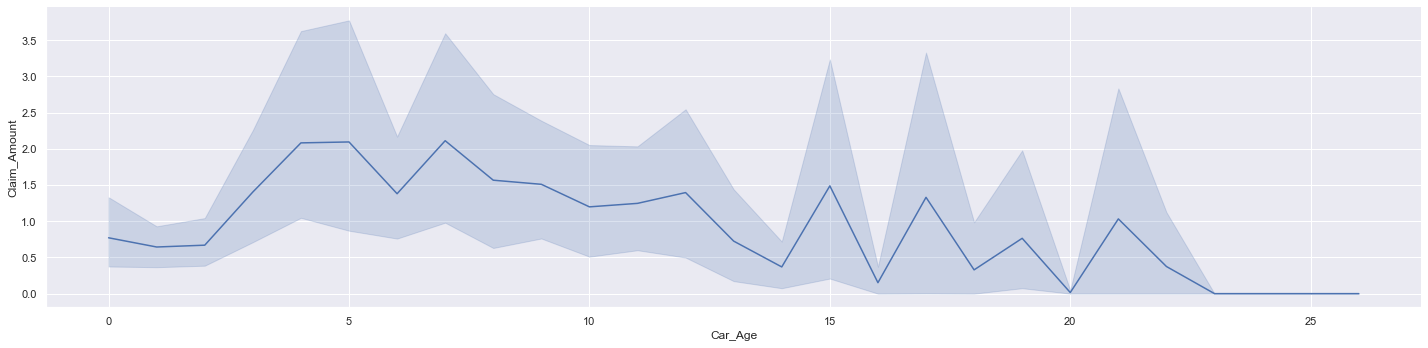

In [52]:
sns.relplot(data=df, x="Car_Age", y="Claim_Amount", kind="line", aspect=4)

Above is plotted the mean and it's 95% CI. We see that the there is relatively high variance in mean claim amount, with peak claim amounts around 4-7 year old cars.

## `Blind_Make`

This variable marks the brand of the car on the policy.

K     12510
AJ    11696
BW     9807
AU     8170
Y      6529
      ...  
BK        1
H         1
B         1
BS        1
AT        1
Name: Blind_Make, Length: 63, dtype: int64
['G' 'BZ' 'Y' 'BW' 'AU' 'AJ' 'K' 'BF' 'Q' 'BP' 'D' 'M' 'AI' 'O' 'W' 'BO'
 'X' 'AN' 'R' 'AQ' 'AL' 'J' 'L' 'BH' 'AV' 'BY' 'BG' 'Z' 'BU' 'AR' 'P' 'AO'
 'AH' 'AY' 'BN' 'BT' 'AW' 'BV' 'BD' 'AX' 'I' 'AC' nan 'BB' 'N' 'AZ' 'AF'
 'BM' 'BA' 'BR' 'V' 'E' 'AD' 'AP' 'BS' 'F' 'B' 'AG' 'U' 'H' 'AT' 'AE' 'S'
 'BK']


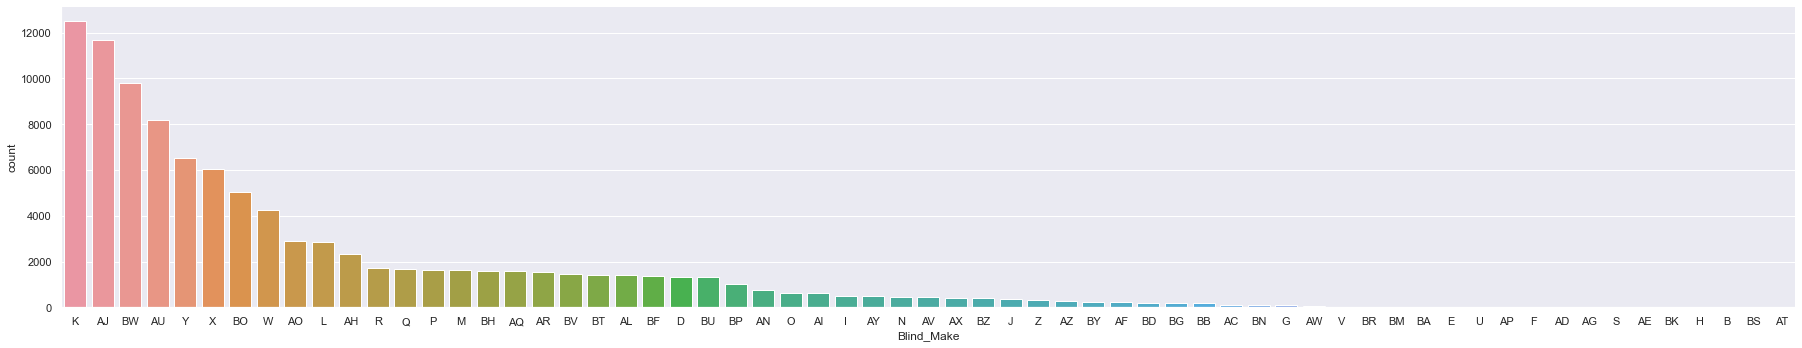

In [53]:
print(df.Blind_Make.value_counts())
print(df.Blind_Make.unique())
sns.catplot(x="Blind_Make", data=df, kind="count", aspect=5, order=df.Blind_Make.value_counts().index)

There are 62 different car makes in the dataset, heavily unbalanced representation of makes. We should concider training the model on only categories represented over some threshold.

### What do car make, model and submotel say about the Claim Amount

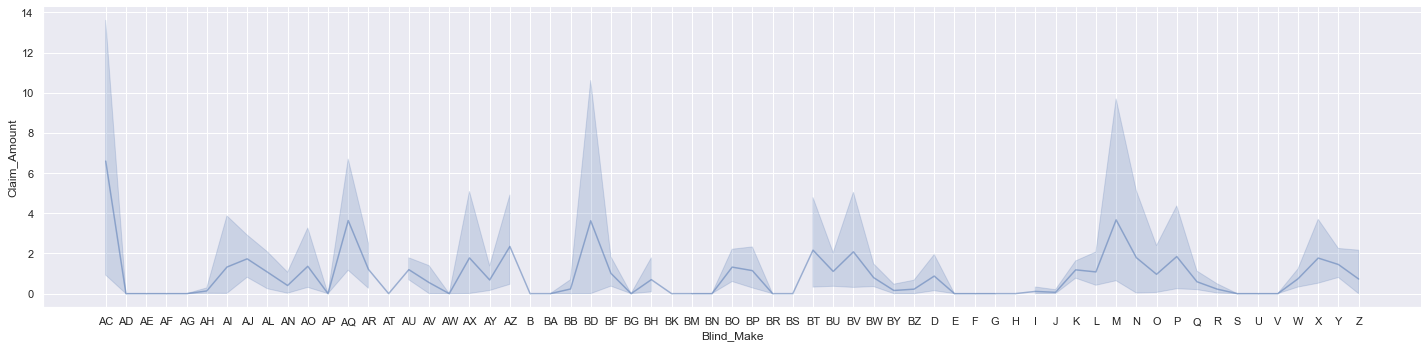

In [54]:
sns.relplot(data=df, x="Blind_Make", y="Claim_Amount", kind="line", aspect=4, alpha=0.5)

## `Blind_Model`

In [55]:
print(df.Blind_Model.value_counts())

K.7      4544
AU.14    2299
X.45     2162
W.16     1794
AU.11    1526
         ... 
BT.5        1
BH.19       1
BW.25       1
BH.48       1
AJ.63       1
Name: Blind_Model, Length: 999, dtype: int64


As there are a great number of unique `Blind_Model` values, we will see if the feature is at all beneficial for the model accuracy. It might case overfitting. 

## Categorical features

In [56]:
categorical_columns = df.columns[df.columns.str.match(pat=r"Cat[1-9]|OrdCat|NVCat")]

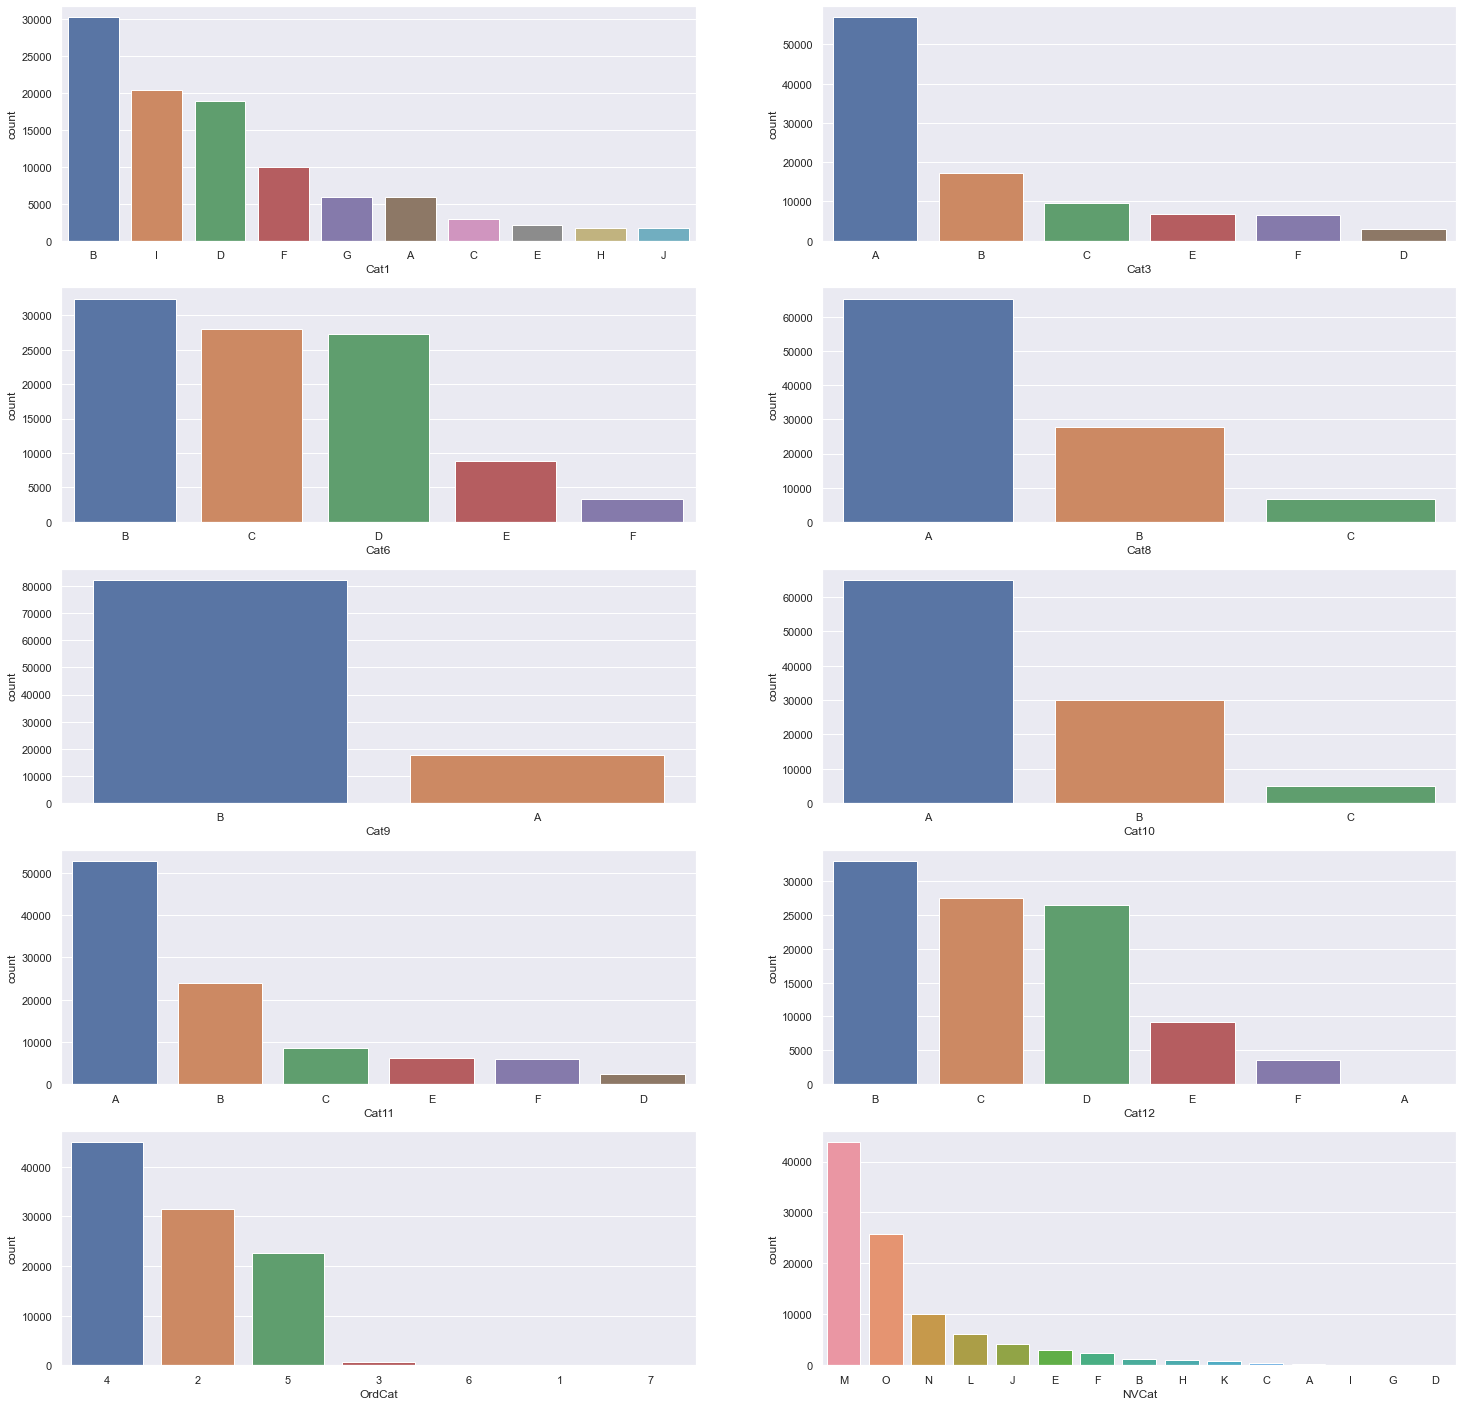

In [57]:
fig, axes = plt.subplots(ncols=2, nrows=np.int(np.ceil(len(categorical_columns)/2)), figsize=(25, 25))

for i, ax in enumerate(axes.flatten()):
    try:
        sns.countplot(x=categorical_columns[i], data=df, ax=ax, order=df[categorical_columns[i]].value_counts().index)
    except IndexError:
        pass
plt.show()

Categorical vehicle and one non-vehicle variable are unevenly distributed. This might be a source of model bias, so we would perhaps need to exclude categories with only small amounts of data.

### How `Claim_Amount` correspons to Categorical variables 

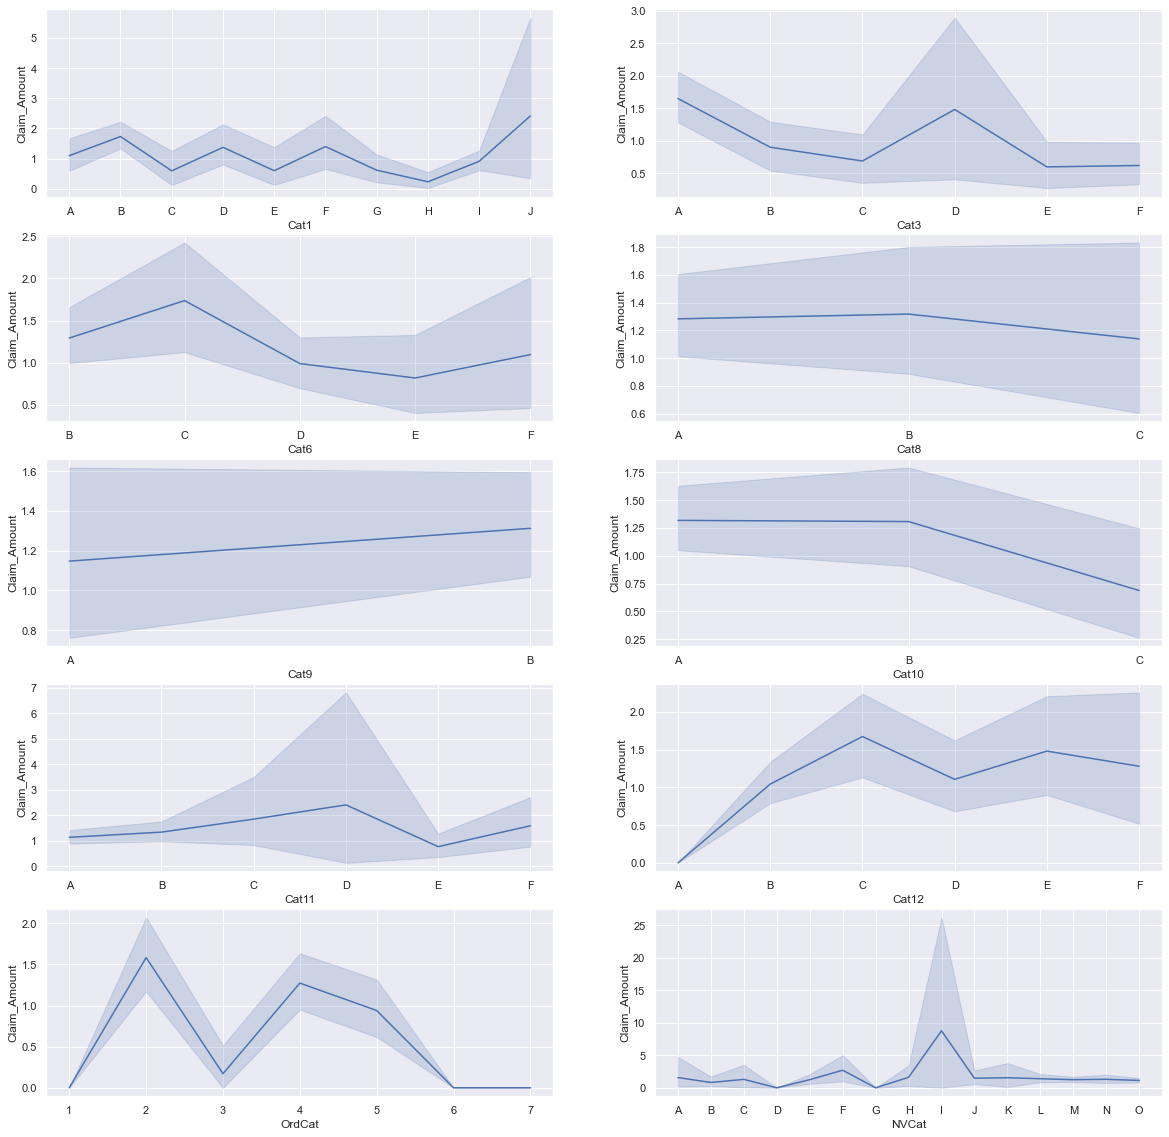

In [58]:
fig, axes = plt.subplots(ncols=2, nrows=np.int(np.ceil(len(categorical_columns)/2)), figsize=(20, 20))

for i, ax in enumerate(axes.flatten()):
    try:
        sns.lineplot(x=categorical_columns[i], y="Claim_Amount", data=df, ax=ax)
    except IndexError:
        pass
    
plt.show()

## Continuous variables

In [59]:
continuous_variables = df.columns[df.columns.str.match(pat=r"Var[1-9]|NVVar")]

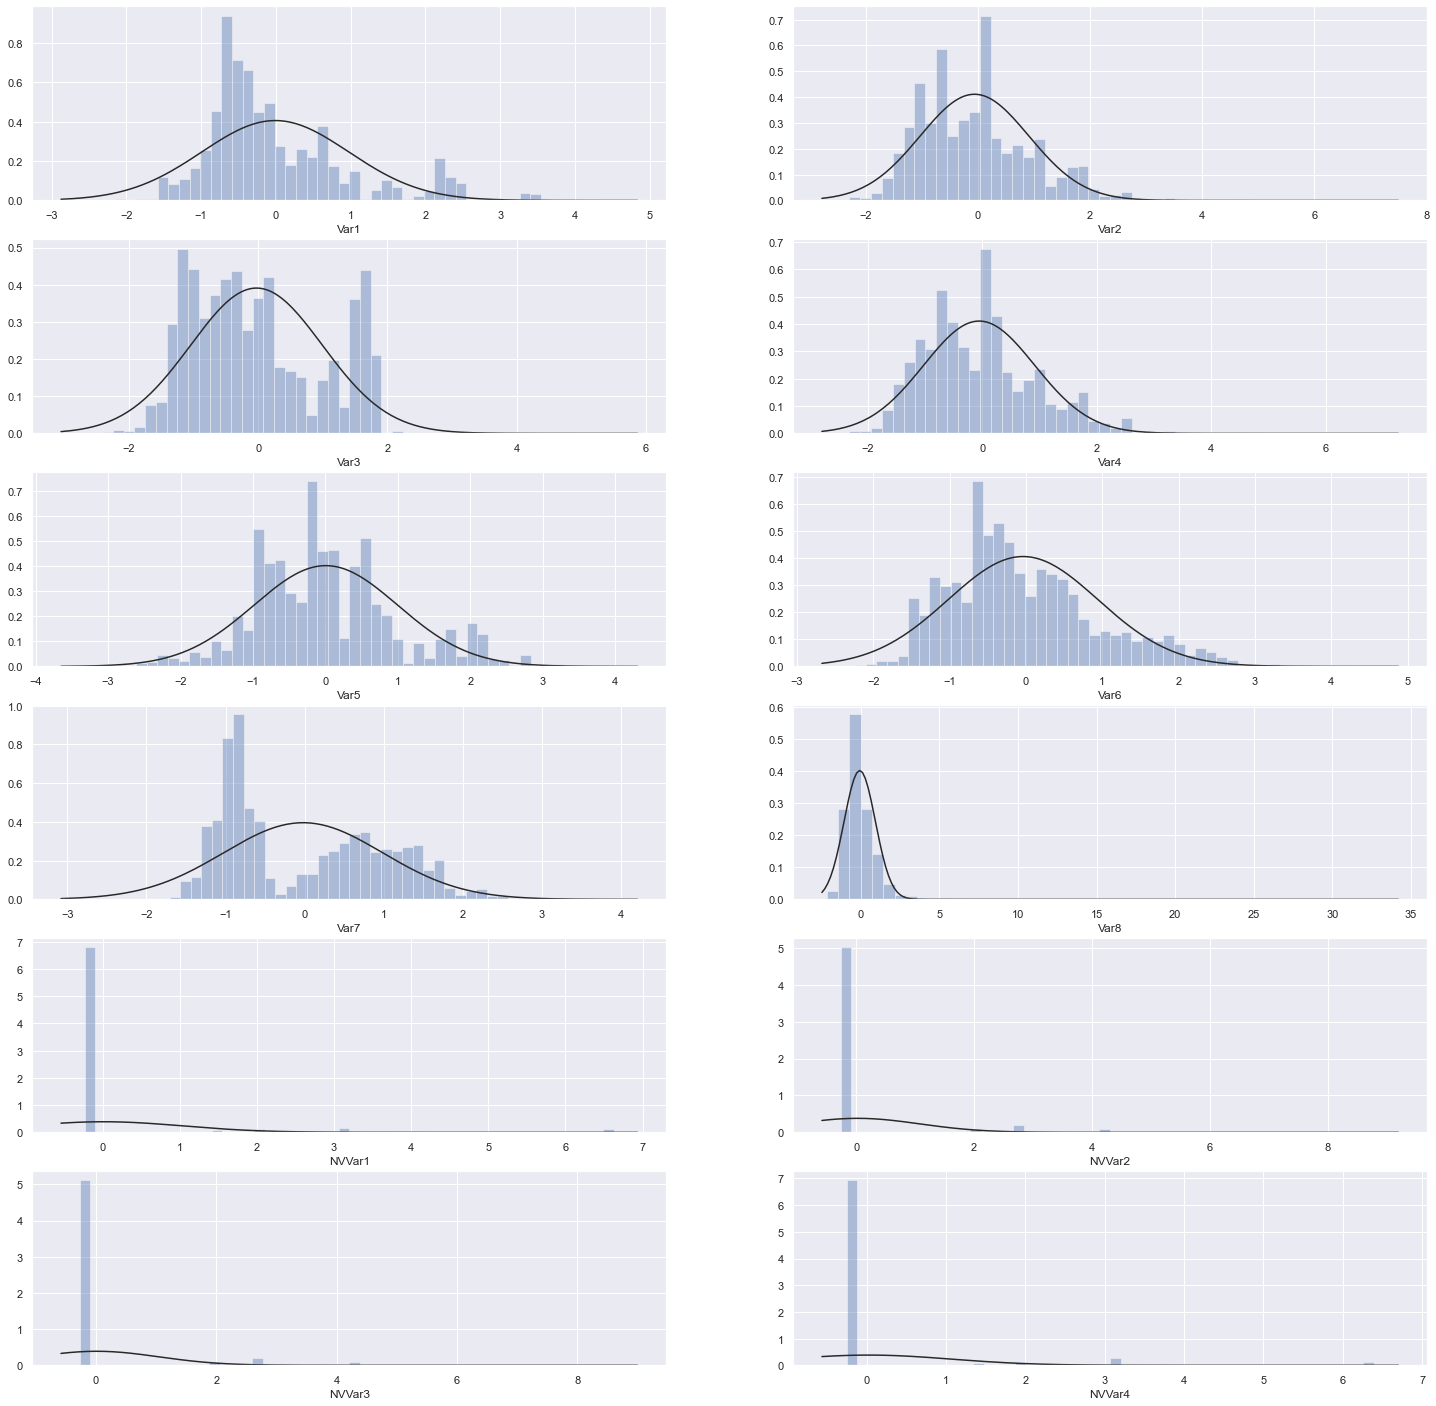

In [60]:
fig, axes = plt.subplots(ncols=2, nrows=np.int(np.ceil(len(continuous_variables)/2)), figsize=(25, 25))

for i, ax in enumerate(axes.flatten()):
    try:
        sns.distplot(df[continuous_variables[i]], fit=stats.norm, kde=False, ax=ax)
    except IndexError:
        pass
plt.show()

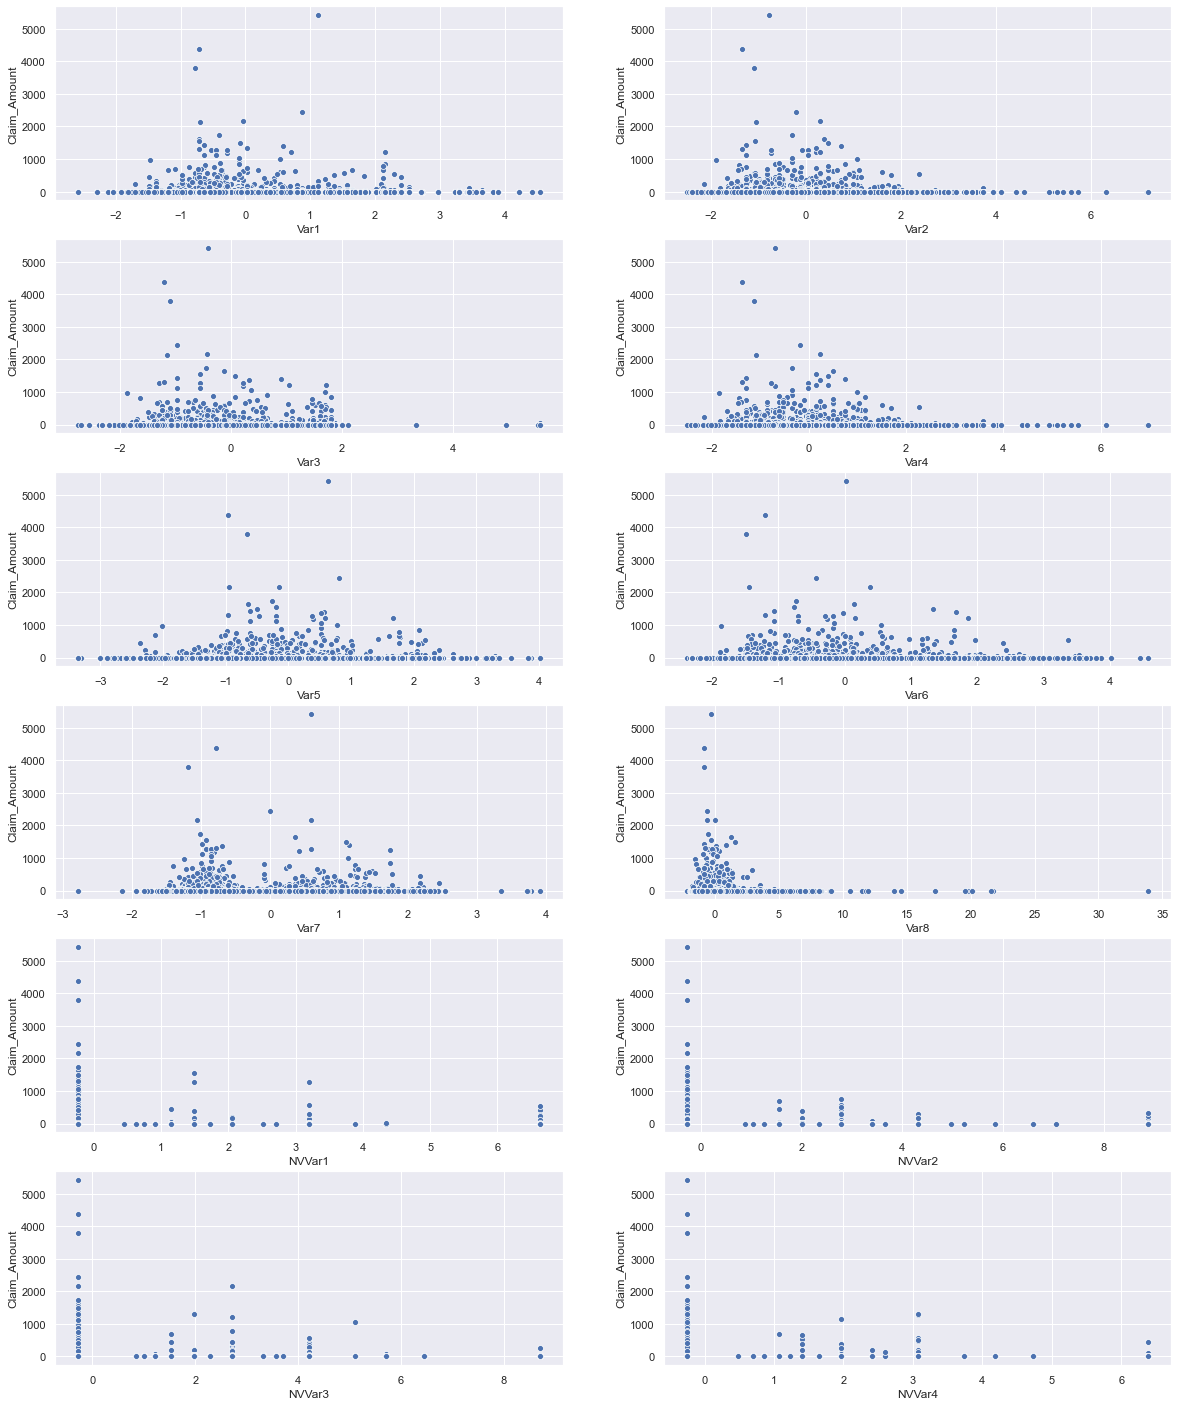

In [61]:
fig, axes = plt.subplots(ncols=2, nrows=np.int(np.ceil(len(continuous_variables)/2)), figsize=(20, 25))

for i, ax in enumerate(axes.flatten()):
    try:
        sns.scatterplot(x=continuous_variables[i], y="Claim_Amount", data=df, ax=ax)
    except IndexError:
        pass
    
plt.show()

## Correlations

In [62]:
# create additional indicator column on whether the claim amount was positive
df = df.assign(Claim_Amount_Positive= lambda x: x.Claim_Amount > 0)

In [63]:
corr_spearman = df[df.Claim_Amount_Positive==True].corr(method="spearman")
corr_pearson = df[df.Claim_Amount_Positive==True].corr(method="pearson")

corr_spearman_all = df.corr(method="spearman")
corr_pearson_all = df.corr(method="pearson")

Text(0.5, 1.0, 'Spearman coefficients')

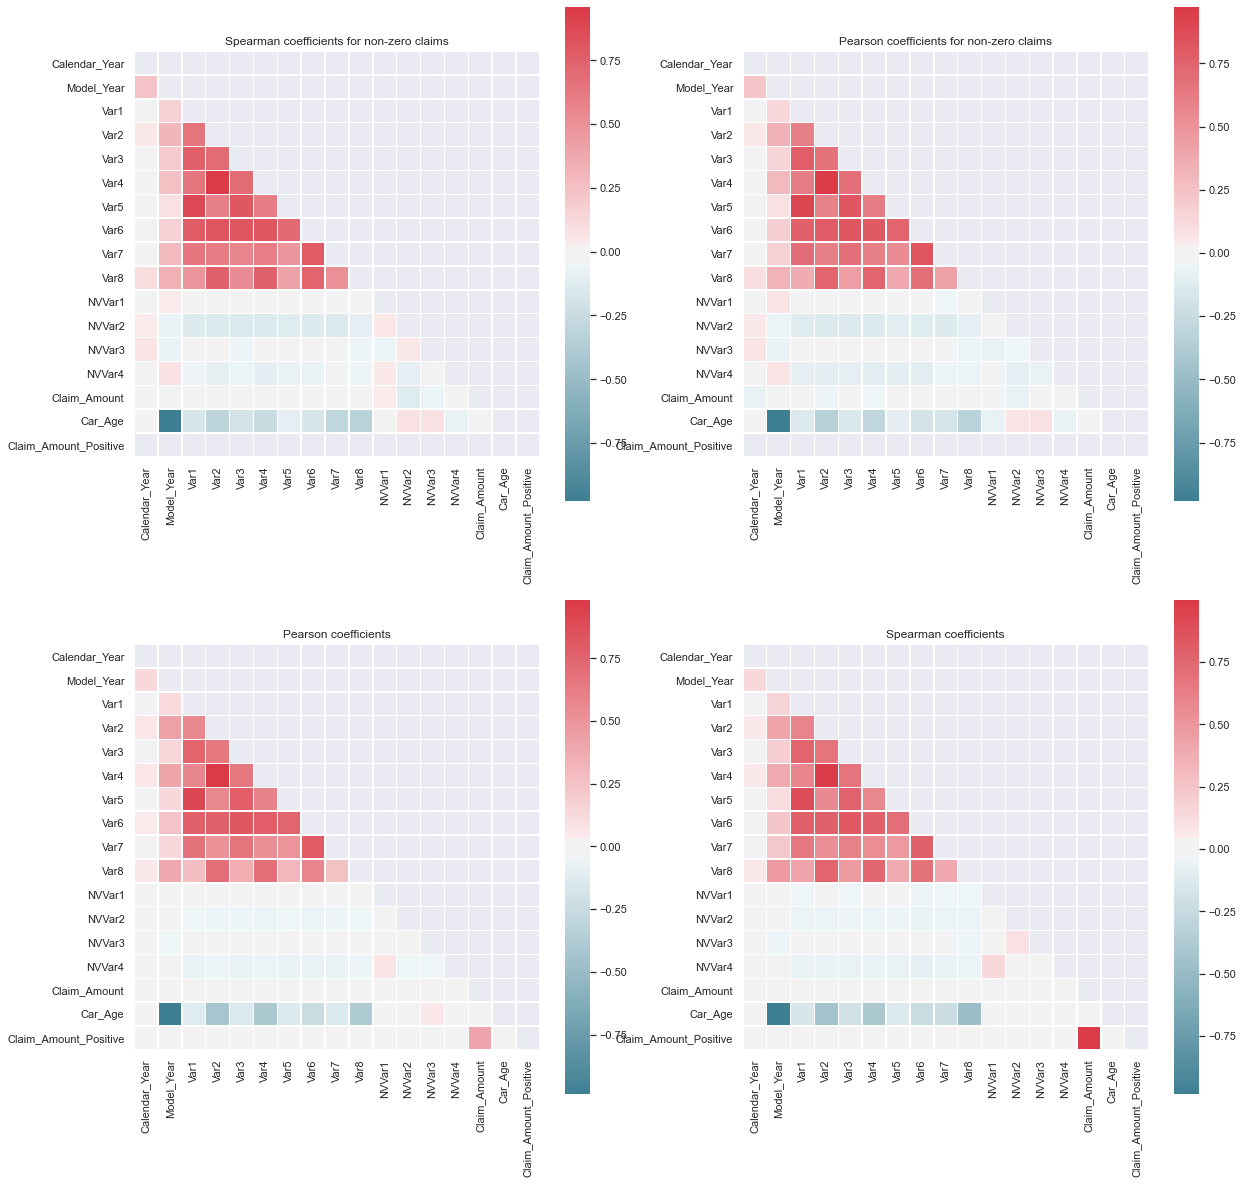

In [64]:
# Draw the heatmap with the mask and correct aspect ratio
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_spearman, dtype=np.bool))

f, ax = plt.subplots(2, 2, figsize=(20, 20))

plt_spear = sns.heatmap(corr_spearman, cmap=cmap, mask=mask, square=True, linewidths=.5, ax=ax[0, 0])
plt_pears = sns.heatmap(corr_pearson, cmap=cmap, mask=mask, square=True, linewidths=.5, ax=ax[0, 1])
plt_pears_all = sns.heatmap(corr_pearson_all, cmap=cmap, mask=mask, square=True, linewidths=.5, ax=ax[1, 0])
plt_spear_all = sns.heatmap(corr_spearman_all, cmap=cmap, mask=mask, square=True, linewidths=.5, ax=ax[1, 1])


plt_spear.set_title("Spearman coefficients for non-zero claims")
plt_pears.set_title("Pearson coefficients for non-zero claims")
plt_pears_all.set_title("Pearson coefficients")
plt_spear_all.set_title("Spearman coefficients")

We see that continuous vehicle variables `Var1-8` are highly correlated. As well, `Car_Age`seems to be mildly correlated to some continuous vehicle variables (namely `Var2, Var4, Var8`). Slight correlation (Spearman estimate of nonparametric monotonous relationships - upper left quadrant) for `Claim_Amount` is evident for non-zero claims.

## `Claim_Amount` [TARGET]

/Users/rok-mi/my_projects/ektimo-test/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(-1.0, 600.0)

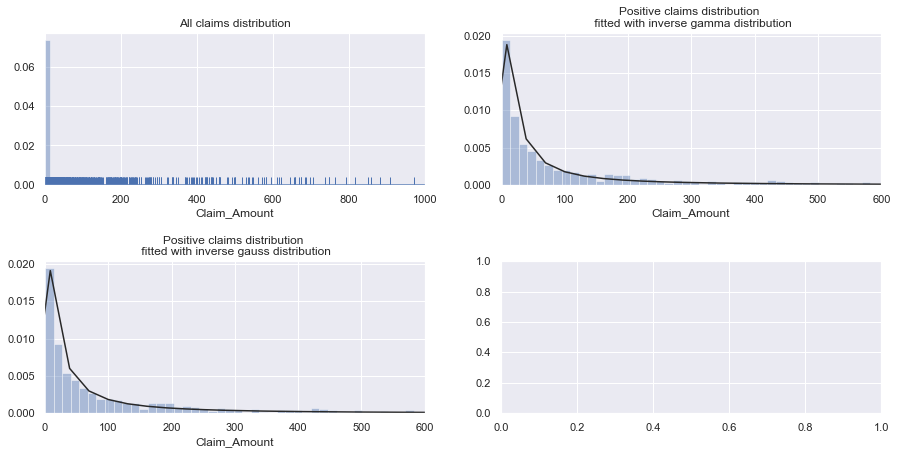

In [65]:
positive_claims = df.Claim_Amount[df.Claim_Amount_Positive == True]

fig, axes = plt.subplots(2, 2, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)

bins=400
plt_all = sns.distplot(a=df["Claim_Amount"], ax=axes[0, 0], rug=True, bins=bins)
plt_all.set_title("All claims distribution")
plt_all.axes.set_xlim(-1, 1000)

plt_poz_inv_gamma = sns.distplot(a=positive_claims, ax=axes[0, 1], kde=False, fit=stats.invgamma, bins=bins)
plt_poz_inv_gamma.set_title("Positive claims distribution \n fitted with inverse gamma distribution")
plt_poz_inv_gamma.axes.set_xlim(left=-1, right=600)
# plt_poz_inv_gamma.axes.set_ylim(top=0.007)

plt_poz_inv_gauss = sns.distplot(a=positive_claims, ax=axes[1, 0], kde=False, fit=stats.invgauss, bins=bins)
plt_poz_inv_gauss.set_title("Positive claims distribution \n fitted with inverse gauss distribution")
plt_poz_inv_gauss.set_xlim(left=-1, right=600)
# plt_poz_inv_gamma.axes.set_ylim(top=0.007)

Both inverse gauss and inverse gamma distributions accuratelly match the distribution of non-zero claim amounts.

(0.0, 100.0)

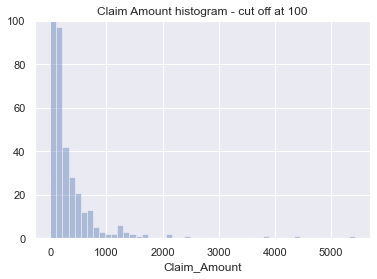

In [66]:
g = sns.distplot(df.Claim_Amount, kde=False).set_title("Claim Amount histogram - cut off at 100")
g.axes.set_ylim(top=100)

In [67]:
claim_amount_cumsum = df.reset_index().groupby("Claim_Amount")["Claim_Amount"].sum()

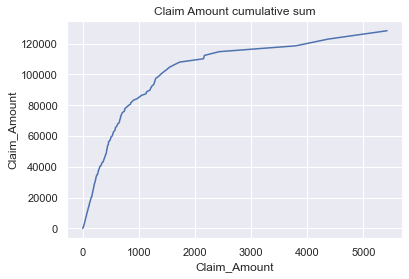

In [68]:
g = sns.lineplot(x=claim_amount_cumsum.index, y=claim_amount_cumsum.cumsum()).set_title("Claim Amount cumulative sum")
# g.axes.set_ylim(top=100)

In [69]:
# Did any household vehicle have more than one occurence?
grouped_claim_occurence_frequency = df.groupby(df.index)["Claim_Amount_Positive"].sum().astype(int)
grouped_claim_occurence_frequency[grouped_claim_occurence_frequency>0].describe()

count    718.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Claim_Amount_Positive, dtype: float64

Maximum **non-zero claim amount frequency** per household-vehicle pair in the dataset was 1 occurrence, so we didn't make any adjustments for the frequency of occurence.

# Model building

## Strategy and alternatives

From the exploration part it is clear we are dealing with **non-linear** relationships between predictors and the predicted variable. The following approaches are viable choices:

1. **Tree based methods (boosting, decision trees)**

**Pros:**
- Less need to preprocess data (scaling, normalization, imputing missing data)
- Easily explainable and visualised

**Cons:**
- Non-robust: small change in the data can cause a large change in the final tree
- We don't get a "final equation", tying together predictors and predicted values with coefficients


2. **Generalized linear models (GLM)**

**Pros:**
- Allows us model and understand the effect on predicted variable of each predictor separately, so we get a useful connection

**Cons:**
- Model is only additive, interactions between variables can be missed.


Since we want to retain the connection between single predictors and the predicted value, we will go for **GLM approach**.

## Modeling options

- It would be possible to model each separately (`p_occurrence` with binomial model & `ev_severity` with Generalized linear model ) and build a composite model.

- Another option is to have single model for occurence and severity directly. **We will use this approach.**

The goal is to calculate **expected value of single insurance claim**, so from this we can calculate the **total expected cost of all insurance policies** in our portfolio.

> Although the non-zero claims follow an inverse gamma and inverse gauss distribution, neither fit the distribution we are modelling itself. Example of Tweedie distributions:

![alt text](https://miro.medium.com/max/1000/1*86MFunZoy0P1c962Dw5UsA.png "Tweedie distribution")


Tweedie distribution family consists of multiple exponential dispersion model distributions (EDM). Depending on a specified power parameter `P` if can follow:

- normal distribution (P=0)
- poisson distribution (P=1)
- **compound poisson-gamma distribution (1 < P < 2)** - this one interests us
- gamma distribution (P >= 2)


## Processing pipeline

Goal is to have a standard processing pipeline with the following:

- fit (hot encode) categorical variables
- standardise X predictors
- drop unused variables
- split to train and test dataset


In [70]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

In [71]:
# variables used
numeric_features = [
    'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
    'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4'
]

categorical_features = [
    'Blind_Make'
#     'Cat1', 'Cat3', 'Cat6', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12',
#     'OrdCat', 'NVCat'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler()), # numeric values are already scaled
#     ('pca', PCA(n_components=2)) # we will let TweedieRegressor handle penalisation
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # take the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])




## Save features to database

In [72]:
# select used features and subset original dataset
used_features = ["Car_Age"] + categorical_features + numeric_features
df_features = df[used_features].reset_index(drop=True)

In [76]:
# establish connection again
conn = db.connect()

In [77]:

try:
    # save features to sqlite
    df_features.to_sql("features", con=conn, if_exists="replace", index=False)
    
     # test if worked
    rs = conn.execute("SELECT * FROM features LIMIT 1")
    
    for row in rs:
        print(row)
    
    # close connection
    conn.close()
    
except Exception as e:
    raise e
    

(9, 'G', -1.059611, -0.8161519, -0.7771260999999999, -0.8675874, -0.9655396, -1.0045867, -1.4391406999999998, -0.9186886000000001, -0.2315299, -0.2661168, -0.27233720000000006, -0.2514189)


In [78]:
# we won't work with database anymore, lets dispose the connection pool
db.dispose()

In [79]:
# define column transformer
column_trans = ColumnTransformer(
    transformers=[
        ("cat_tf", categorical_transformer, categorical_features),
        ("num_tf", numeric_transformer, numeric_features),
        
        # standard scaling
        ("standard_scaler", StandardScaler(),
            ["Car_Age"] # we will standardise the car age
        )
        
    ],
    remainder="drop", # drop remaining columns
)

# Training

## Train test split

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
# we will split the dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df["Claim_Amount"], train_size=0.75, random_state=2 
)

In [82]:
X_train_tf = column_trans.fit_transform(X_train)
y_train = y_train.values 

X_test_tf = column_trans.transform(X_test)
y_test = y_test.values

In [83]:
def percent_non_zero_claims(targets_array):
    """ Returns percent of non zero claims in train/test set"""
    percent = len(targets_array[targets_array>0])/len(targets_array)*100
    return round(percent, 3)

In [84]:
# let's check if non-zero claims are roughly equally represented
print(f"Percent of non-zero claims in train set {percent_non_zero_claims(y_train)}, total count: {len(y_train)}")
print(f"Percent of non-zero claims in test set {percent_non_zero_claims(y_test)}, total count: {len(y_test)}")

Percent of non-zero claims in train set 0.697, total count: 75000
Percent of non-zero claims in test set 0.78, total count: 25000


## Model initialization

In [85]:
from sklearn.linear_model import TweedieRegressor
from functools import partial

In [86]:
# here we define the model
models = {
    # I selected power of 1.5 for Tweedie Regressor, 
    # since it most resembles our distribution + later crossvalidated with various Power values
    # log link function connects predictors to the mean of the predicted value
    "TweedieRegressor": TweedieRegressor(power=1.5, link="log", max_iter=100000)
}

# fit the model

for name, model in models.items():
    print(f"Fitting model {name}")
    model.fit(X_train_tf, y_train)

Fitting model TweedieRegressor


## Model assessment

In [95]:
from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error, auc

### MAE and mean tweedie deviance

We will score the model with **mean absolute error** (MAE) and **mean tweedie deviance**.

**Mean tweedie deviance** - This function computes the mean Tweedie deviance error, which depends on the power parameter **P**. Formula is the following:

![Mean tweedie deviance](./static/mean_tweedie_deviance.png "Mean tweedie deviance")

**Mean absoulte error** - MAE computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss.

![Mean absolute error](./static/mae.png "Mean absolute error")

In [88]:
def score_estimator(
    estimator, X_train, X_test, y_train, y_test,
    tweedie_powers=[1.0, 1.5, 2.0],
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error)     
    ]
    
    if tweedie_powers:
        metrics += [(
            f"mean tweedie dev p={power}",
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    
    for subset_label, X, target in [
        ("train", X_train, y_train),
        ("test", X_test, y_test),
    ]:
        for score_label, metric in metrics:
           
            y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, target)
            else:
                score = metric(target, y_pred)   
        
            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

In [89]:
print("MAE and Mean Tweedie deviance Score of Tweedie regressor model \nwith varying power parameter")
score_estimator(
    models["TweedieRegressor"], 
    X_train_tf, X_test_tf, y_train, y_test, tweedie_powers=[1.0, 1.4, 1.5, 1.6,  1.8, 1.9])

MAE and Mean Tweedie deviance Score of Tweedie regressor model 
with varying power parameter


subset,train,test
metric,,
D² explained,0.0164,0.0186
mean abs. error,2.5248,2.5217
mean tweedie dev p=1.0,15.4957,14.8886
mean tweedie dev p=1.4,8.5503,8.4555
mean tweedie dev p=1.5,8.3718,8.3052
mean tweedie dev p=1.6,8.7276,8.6782
mean tweedie dev p=1.8,12.8072,12.7735
mean tweedie dev p=1.9,22.4219,22.3857


We cross-validated the mean tweedie deviance and it has minimum error with **P=1.5**, so we are using this as TweedieRegressor input

### Total claim amount for train and test data (observed and predicted)

In [90]:
res = []
for label, X, targets in [
    ("train", X_train_tf, y_train),
    ("test", X_test_tf, y_test)
]:

    tweedie_model = models["TweedieRegressor"]
    predicted = tweedie_model.predict(X)
    res.append(
        {
            "label": label,
            "observed": np.sum(targets),
            f"tweedie_model_predicted, p={tweedie_model.power}": np.sum(predicted),
            "% diff": 100*(np.sum(predicted) - np.sum(targets)) / np.sum(targets)
        }
    )
    
print("Observed and predicted cumulative sum of claim amounts for train and test data")

pd.DataFrame(data=res).set_index("label").T


Observed and predicted cumulative sum of claim amounts for train and test data


label,train,test
observed,96211.298250,32092.885942
"tweedie_model_predicted, p=1.5",94498.089926,31460.239627
% diff,-1.780673,-1.971298


Both in training and test data the model underestimates the cumulative claim amount by **little less than 2%** which is a satisfactory result.

### Lorenz curve

We will assess the model for it's **ability to rank the policies according to riskines**. Household vehicle insurance policies are ranked from safest to riskiest and the fraction of observed total cumulated claims is plotted on the y axis.

The Gini index is be used to quantify the model's ability to correctly rank the riskiness.

In [91]:
def lorenz_curve(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    
    # order true targets by ranking of predicted targets
    ranked_claim_amount = y_true[ranking]
    
    # calculate cumulative sum of true targets
    cumulated_claim_amount = np.cumsum(ranked_claim_amount)
    
    # divide every cumulated claim amount with total cumulated amount to get fractions 
    cumulated_claim_amount = cumulated_claim_amount / cumulated_claim_amount[-1]
    
    # x axis points
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    
    return cumulated_samples, cumulated_claim_amount

In [92]:
def gini_auc(ord_sample, cum_claims):
    return 1 - 2 * auc(ordered_samples, cum_claims)

[]

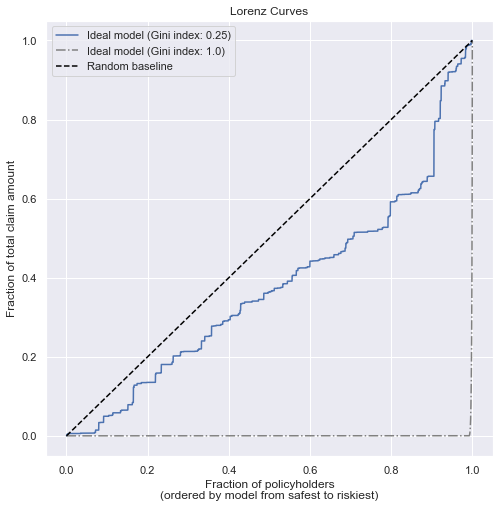

In [96]:
fig, ax = plt.subplots(figsize=(8, 8))

y_test_pred = models["TweedieRegressor"].predict(X_test_tf) 

ordered_samples, cum_claims = lorenz_curve(
        y_test, y_test_pred)
gini = gini_auc(ordered_samples, cum_claims)
label = f"Ideal model (Gini index: {round(gini, 2)})"
ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)


# Ideal model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
     y_test,  y_test)
gini = gini_auc(ordered_samples, cum_claims)

label = f"Ideal model (Gini index: {round(gini, 2)})"
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray",
        label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left")
plt.plot()

We see that the ranking of policy riskiness is not that successful, as ideal Gini index would be > 0.8, and we are receiveing result < 0.3.

### Plotting predictions 

In [97]:
def plot_pred(df, x_var: str, value_var_names: list):
    
    """ 
    Function for ploting predicted values and targets against one independent variable
    
    Parameters
    ----------
    df: pd.DataFrame
        input data
    x_var: str
        name of independent variable to plot against
    value_var_names: list
        dependent variable names (target and predicted)
    """
    
    df = df.melt(
        x_var, var_name="predicted_type", value_vars=value_var_names, value_name="prediction",
    )
    
    df_grouped = df.groupby([x_var, "predicted_type"])["prediction"].mean().reset_index()
    
    plt.figure(figsize=(13, 4))
    # g.map(plt.scatter, "Blind_Make", "y_pred", color="blue", s=100, linewidth=.5)
    g = sns.scatterplot(x_var, "prediction", hue="predicted_type", data=df_grouped)
    g.axes.set_ylim(0, 5)    

In [98]:
# sample fair amount of original data and predict values
sample_df = df.sample(75000)
sample_df["y_pred"] = models["TweedieRegressor"].predict(column_trans.transform(sample_df))

/Users/rok-mi/my_projects/ektimo-test/venv/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


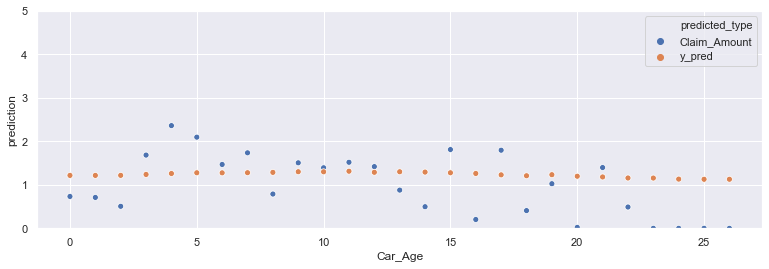

In [99]:
plot_pred(sample_df, "Car_Age", ["y_pred", "Claim_Amount"])

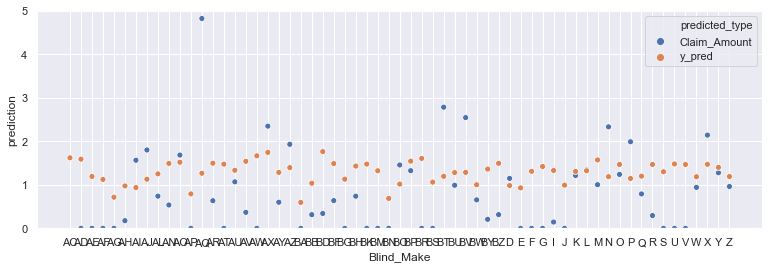

In [100]:
plot_pred(sample_df, "Blind_Make", ["y_pred", "Claim_Amount"])

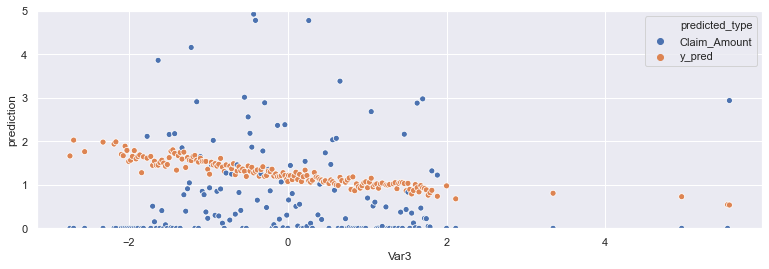

In [101]:
plot_pred(sample_df, "Var3", ["y_pred", "Claim_Amount"])

## Save model artifacts

In [102]:
from joblib import dump, load
import datetime
import os

In [103]:
def export_model_artifact(model, name, export_path):
    
    now = datetime.datetime.now()
    now_string = datetime.datetime.strftime(now, format="%Y-%m-%d %H:%M")
    
    export_path = os.path.join("../models", export_path)

    if not os.path.exists(export_path):
        os.makedirs(export_path)
    
    export_loc = os.path.join(export_path, name+"_"+now_string+".joblib")
    dump(model, export_loc)

In [104]:
export_model_artifact(model=column_trans, name="column_transformer", 
                     export_path="claim_amount/tweedie_regressor/artifacts")

export_model_artifact(model=models["TweedieRegressor"], name="Tweedie_Regressor", 
                     export_path="claim_amount/tweedie_regressor/artifacts")

## Load model artifacts

In [108]:
col_transformer_load = load(
    "../models/claim_amount/tweedie_regressor/artifacts/column_transformer_2020-05-31 19:09.joblib")

In [109]:
tweedie_model_loaded = load(
    "../models/claim_amount/tweedie_regressor/artifacts/Tweedie_Regressor_2020-05-31 19:09.joblib")

In [110]:
X_test_tf_new = col_transformer_load.transform(X_test)
y_test_pred_new = tweedie_model_loaded.predict(X_test_tf_new)

print(y_test_pred_new[:10])

[1.77268418 1.00420413 1.25400833 1.0552512  0.9999156  1.71695603
 1.36761174 1.58154773 0.73475632 1.45654357]
